<a href="https://colab.research.google.com/github/SanjanaPushpita/Detectron2/blob/main/Detectron2_custom_data-confusion%20matrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Install dependencies
!pip install -U torch torchvision
!pip install opencv-python

# Install Detectron2
# Install the pre-built version specific to the current PyTorch version:
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

# Verify installation by importing Detectron2
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# Check if it was installed correctly
import torch, torchvision
print(f"Torch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

# Test a simple import from Detectron2 and OpenCV
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
import cv2
print("Detectron2 and OpenCV are ready to use!")


  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-gzu0rqb7
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-gzu0rqb7
  Resolved https://github.com/facebookresearch/detectron2.git to commit 8d85329aed8506ea3672e3e208971345973ea761
  Preparing metadata (setup.py) ... done
Torch version: 2.5.0+cu124
CUDA available: True
Detectron2 and OpenCV are ready to use!


In [3]:
import zipfile

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import shutil

# # Define the source and destination paths
# src = '/content/drive/MyDrive/Dental/Dataset/Pediatric dental disease detection dataset'
# dst = '/content/Pediatric_dental_disease_detection_dataset'

# # Copy the folder
# shutil.copytree(src, dst)

In [4]:
import os
# Define the paths to your zip files
children_dental_dataset = '/content/drive/MyDrive/Dental dataset.zip'

# Unzipping the files to a specific directory (e.g., '/content/Children_Dental')
os.system(f'unzip "{children_dental_dataset}" -d /content/Children_Dental')

0

In [5]:
from detectron2.data import MetadataCatalog
from detectron2.utils.visualizer import ColorMode, Visualizer
from detectron2.data.datasets import register_coco
from detectron2 import model_zoo

import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt
%matplotlib inline

from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog

from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()


from google.colab.patches import cv2_imshow



In [6]:
def cv2_imshow(im):
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.figure(), plt.imshow(im), plt.axis('off');

In [7]:
def dental_dataset(img_dir):
    json_file = os.path.join(img_dir, "annotations.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()):
        record = {}

        filename = os.path.join(img_dir, v["filename"])
        height, width = cv2.imread(filename).shape[:2]

        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width

        annos = v["regions"]
        objs = []
        for _, anno in annos.items():
            assert not anno["region_attributes"]
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

# Register the dataset with the new class names
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/content/Children_Dental/Children's dental caries segmentation dataset/Train/annotations.json", "/content/Children_Dental/Children's dental caries segmentation dataset/Train/images")
register_coco_instances("my_dataset_test", {}, "/content/Children_Dental/Children's dental caries segmentation dataset/Test/annotations.json", "/content/Children_Dental/Children's dental caries segmentation dataset/Test/images")


[10/19 14:12:04 d2.data.datasets.coco]: Loaded 70 images in COCO format from /content/Children_Dental/Children's dental caries segmentation dataset/Train/annotations.json


/usr/local/lib/python3.10/dist-packages/detectron2/utils/visualizer.py:318: UserWarning: Glyph 40843 (\N{CJK UNIFIED IDEOGRAPH-9F8B}) missing from current font.
  s, (width, height) = canvas.print_to_buffer()
/usr/local/lib/python3.10/dist-packages/detectron2/utils/visualizer.py:318: UserWarning: Glyph 40831 (\N{CJK UNIFIED IDEOGRAPH-9F7F}) missing from current font.
  s, (width, height) = canvas.print_to_buffer()
/usr/local/lib/python3.10/dist-packages/detectron2/utils/visualizer.py:318: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from current font.
  s, (width, height) = canvas.print_to_buffer()
/usr/local/lib/python3.10/dist-packages/detectron2/utils/visualizer.py:318: UserWarning: Glyph 21106 (\N{CJK UNIFIED IDEOGRAPH-5272}) missing from current font.
  s, (width, height) = canvas.print_to_buffer()


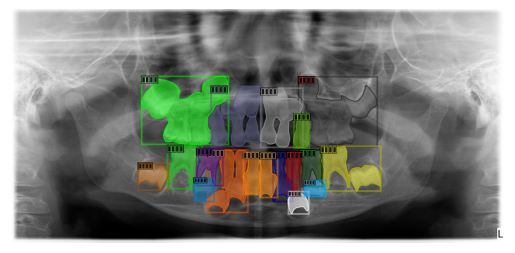

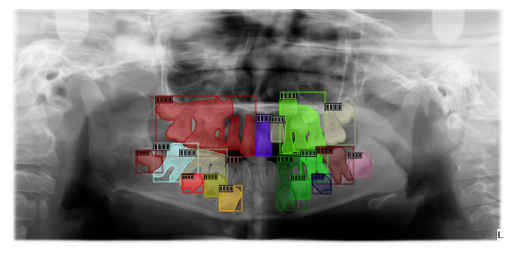

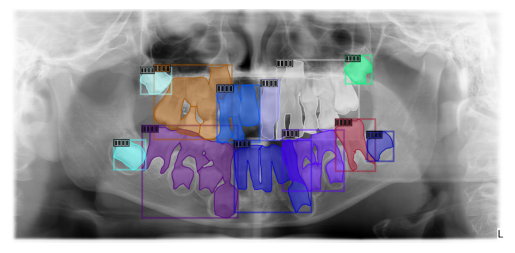

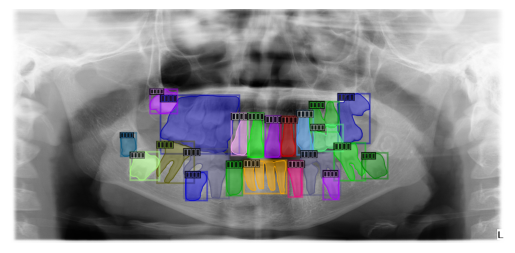

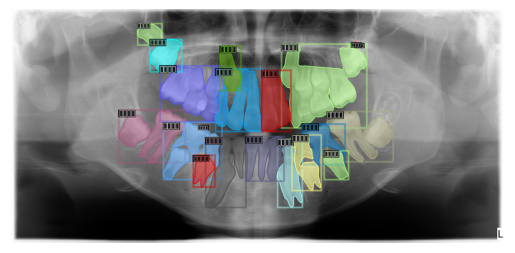

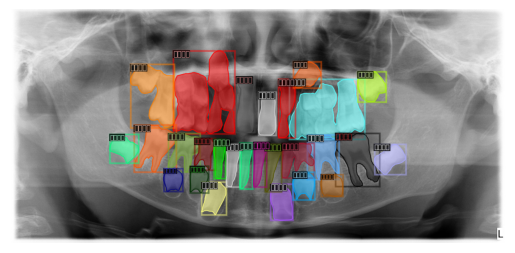

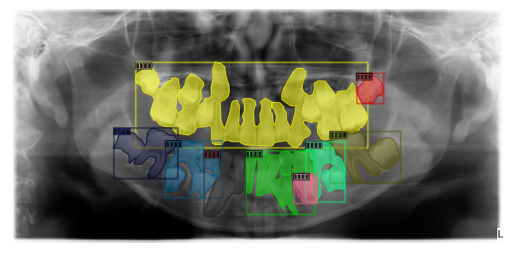

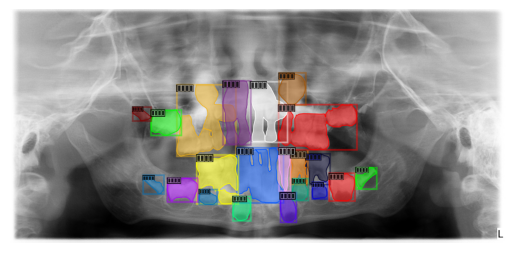

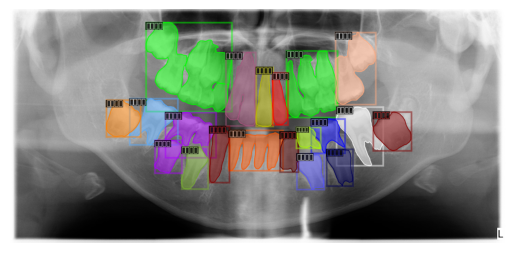

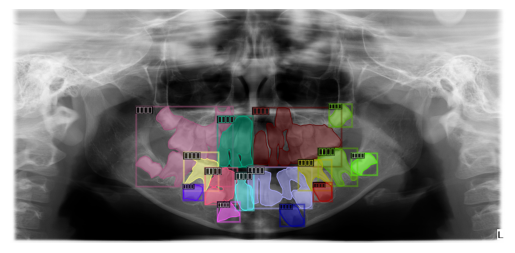

In [8]:
my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train")
dataset_dicts = DatasetCatalog.get("my_dataset_train")

import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 10):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

# Train


In [18]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 6000
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)  # Change this to False
trainer.train()


[10/19 14:17:01 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[10/19 14:17:01 d2.engine.train_loop]: Starting training from iteration 0
[10/19 14:17:15 d2.utils.events]:  eta: 1:07:04  iter: 19  total_loss: 3.718  loss_cls: 1.675  loss_box_reg: 0.7085  loss_rpn_cls: 1.19  loss_rpn_loc: 0.1354    time: 0.6699  last_time: 0.6244  data_time: 0.0313  last_data_time: 0.0120   lr: 4.9953e-06  max_mem: 3474M
[10/19 14:17:29 d2.utils.events]:  eta: 1:04:23  iter: 39  total_loss: 2.932  loss_cls: 1.613  loss_box_reg: 0.775  loss_rpn_cls: 0.4092  loss_rpn_loc: 0.1259    time: 0.6706  last_time: 0.7469  data_time: 0.0151  last_data_time: 0.0281   lr: 9.9902e-06  max_mem: 3476M
[10/19 14:17:42 d2.utils.events]:  eta: 1:03:45  iter: 59  total_loss: 2.586  loss_cls: 1.469  loss_box_reg: 0.7798  loss_rpn_cls: 0.1348  loss_rpn_loc: 0.1161    time: 0.6642  last_time: 0.7080  data_time: 0.0135  last_data_time: 0.0203   lr: 1.4985e-05  max_mem: 3476M
[10/19 14:17:55 d2.utils.events]:  eta: 1:03:22  iter: 79  total_loss: 2.352  loss_cls: 1.264  loss_box_reg: 0.8091 

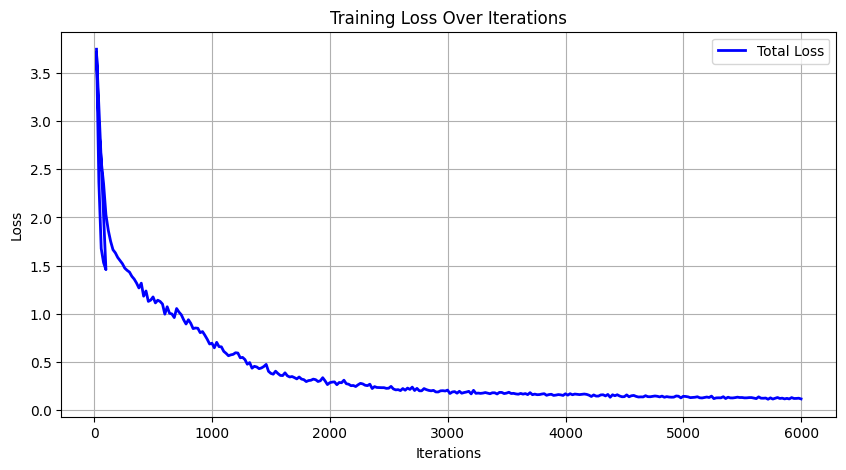

In [19]:
import matplotlib.pyplot as plt
import json
import os

# Path to the metrics JSON file generated during training
metrics_file = os.path.join(cfg.OUTPUT_DIR, "metrics.json")

# Check if the metrics file exists
if os.path.exists(metrics_file):
    # Read the data from the metrics file
    with open(metrics_file, 'r') as f:
        data = [json.loads(line) for line in f]

    # Extract the iteration numbers and total loss values
    iterations = [x['iteration'] for x in data if 'total_loss' in x]
    losses = [x['total_loss'] for x in data if 'total_loss' in x]

    # Plot the training loss
    plt.figure(figsize=(10, 5))
    plt.plot(iterations, losses, label='Total Loss', color='blue', linewidth=2)
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Iterations')
    plt.grid(True)
    plt.legend()
    plt.show()
else:
    print(f"Metrics file not found at {metrics_file}. Ensure that training has been run.")


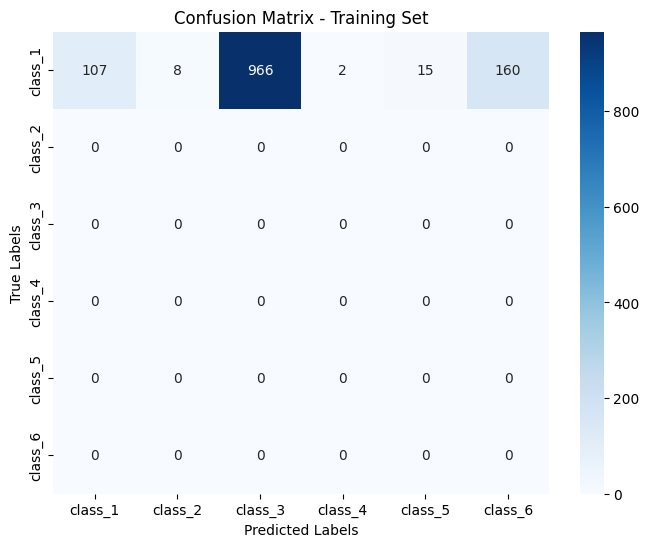

Classification Report - Training Set:
              precision    recall  f1-score   support

     class_1       1.00      0.09      0.16      1258
     class_2       0.00      0.00      0.00         0
     class_3       0.00      0.00      0.00         0
     class_4       0.00      0.00      0.00         0
     class_5       0.00      0.00      0.00         0
     class_6       0.00      0.00      0.00         0

    accuracy                           0.09      1258
   macro avg       0.17      0.01      0.03      1258
weighted avg       1.00      0.09      0.16      1258



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [24]:
# Define the class names manually if `thing_classes` is incorrect or incomplete
class_names = ["class_1", "class_2", "class_3", "class_4", "class_5", "class_6"]

# Compute the confusion matrix
conf_matrix_train = confusion_matrix(true_labels_train, predicted_labels_train)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_train, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - Training Set")
plt.show()

# Display the classification report with the correct class names
print("Classification Report - Training Set:")
print(classification_report(true_labels_train, predicted_labels_train, target_names=class_names))


# **Test**

In [21]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
cfg.DATASETS.TEST = ("my_dataset_test", )
predictor = DefaultPredictor(cfg)

[10/19 15:27:54 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

Processed image: /content/Children_Dental/Children's dental caries segmentation dataset/Test/images/cate2_004.png, Predictions: {'instances': Instances(num_instances=21, image_height=942, image_width=2000, fields=[pred_boxes: Boxes(tensor([[ 569.0090,  248.4074,  958.0634,  562.6884],
        [ 795.5785,  567.7448,  938.2790,  722.6660],
        [ 457.1903,  549.6124,  570.0574,  656.3276],
        [1125.7368,  691.8854, 1207.9844,  783.2833],
        [1225.3544,  691.5490, 1301.1847,  769.9552],
        [1053.4225,  575.6237, 1192.3451,  715.4982],
        [ 682.9536,  678.0847,  764.2808,  754.0786],
        [ 781.1088,  692.6910,  859.8893,  782.5351],
        [ 948.1493,  576.3614,  991.4838,  750.1882],
        [1200.4124,  566.8966, 1450.7313,  747.2592],
        [ 853.1382,  718.3900,  946.9068,  849.7983],
        [1049.5488,  716.0942, 1129.4590,  823.1921],
        [ 995.4567,  580.5827, 1043.1222,  751.0464],
        [1039.4796,  282.4323, 1334.0970,  564.2994],
        [ 54

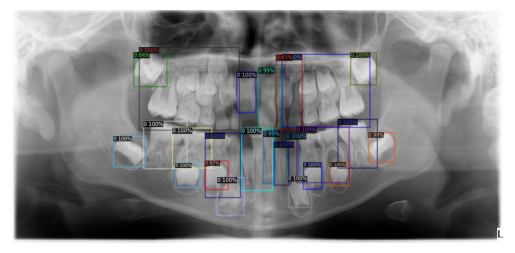

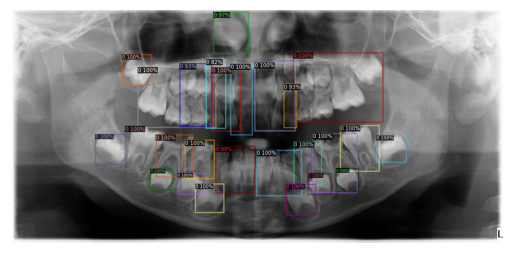

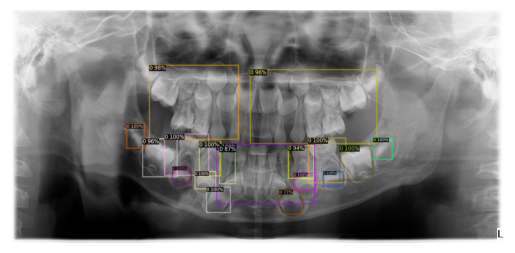

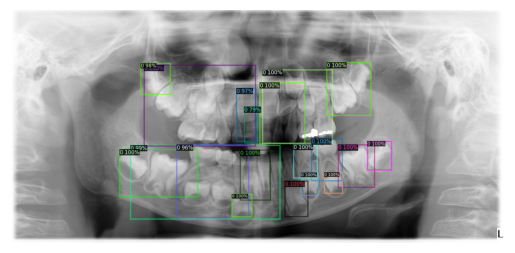

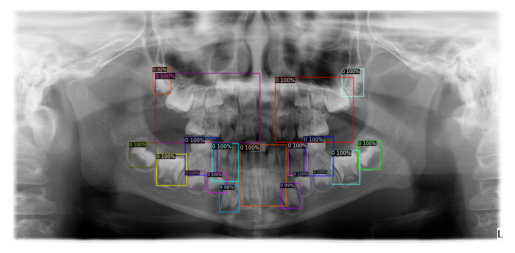

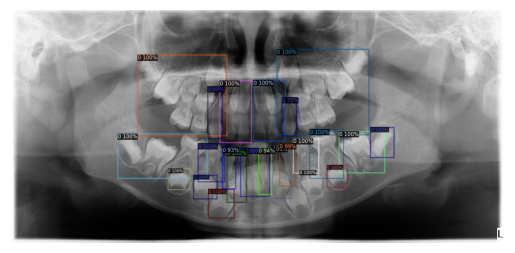

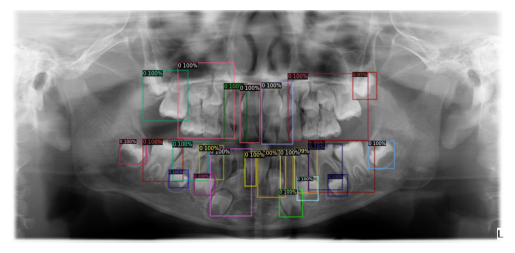

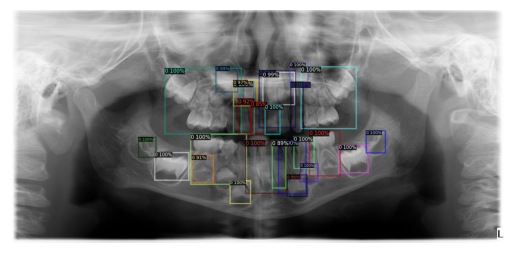

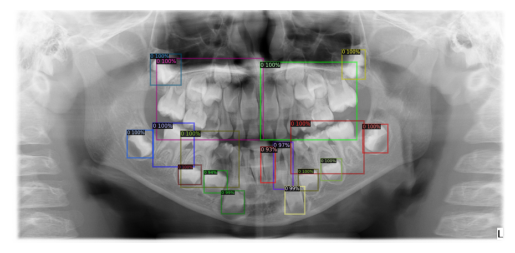

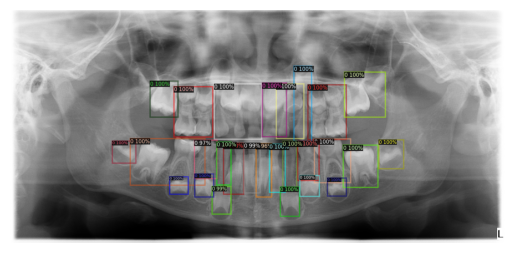

In [22]:
from detectron2.utils.visualizer import ColorMode
import glob

# Retrieve all PNG image file paths from the specified directory
image_paths = glob.glob("/content/Children_Dental/Children's dental caries segmentation dataset/Test/images/*png")

# Limit the number of images to visualize
max_images = 10
image_counter = 0

# Process each image in the list
for img_path in image_paths:
    # Load the current image
    image = cv2.imread(img_path)

    # Make predictions using the trained model
    predictions = predictor(image)

    # Check if we need to visualize the current image
    if image_counter < max_images:
        # Create a visualizer for the current image
        visualizer_instance = Visualizer(image[:, :, ::-1],
                                          metadata=MetadataCatalog.get("my_dataset_test"),
                                          scale=0.8
                                          )
        # Draw the predictions on the image
        visualized_output = visualizer_instance.draw_instance_predictions(predictions["instances"].to("cpu"))
        # Display the image with the drawn predictions
        cv2_imshow(visualized_output.get_image()[:, :, ::-1])
        image_counter += 1
    else:
        # For images beyond the limit, print the predictions
        print(f"Processed image: {img_path}, Predictions: {predictions}")


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 40843 (\N{CJK UNIFIED IDEOGRAPH-9F8B}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 40831 (\N{CJK UNIFIED IDEOGRAPH-9F7F}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 21106 (\N{CJK UNIFIED IDEOGRAPH-5272}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151

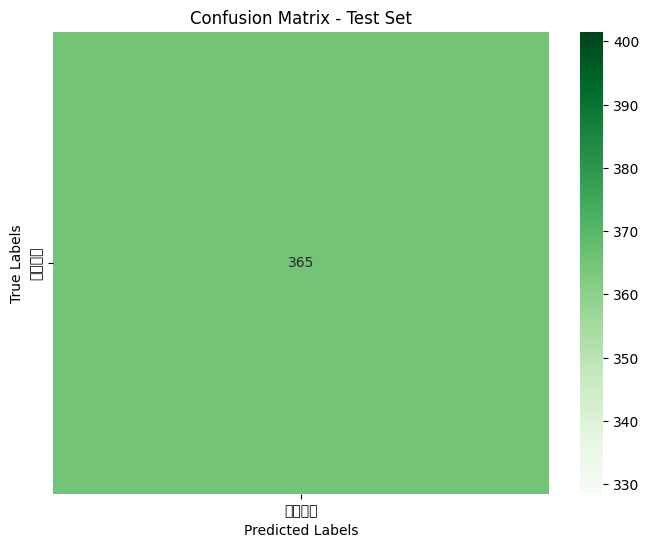

Classification Report - Test Set:
              precision    recall  f1-score   support

        龋齿分割       1.00      1.00      1.00       365

    accuracy                           1.00       365
   macro avg       1.00      1.00      1.00       365
weighted avg       1.00      1.00      1.00       365



In [23]:
# Initialize lists for storing true labels and predicted labels for the test set
true_labels_test = []
predicted_labels_test = []

# Process each image and gather true and predicted labels
for img_path in image_paths:
    image = cv2.imread(img_path)
    outputs = predictor(image)
    pred_classes = outputs["instances"].pred_classes.cpu().numpy()

    # Extract true labels from the dataset (assuming annotation exists)
    image_id = img_path.split("/")[-1].split(".")[0]  # Get image ID
    annotations = [x for x in dataset_dicts if x["file_name"].endswith(image_id + ".png")]

    if len(annotations) > 0:
        true_classes = [anno["category_id"] for anno in annotations[0]["annotations"]]

        # Match the length of predictions and true labels:
        min_length = min(len(true_classes), len(pred_classes))
        true_labels_test.extend(true_classes[:min_length])
        predicted_labels_test.extend(pred_classes[:min_length])

# Compute the confusion matrix for the test set
conf_matrix_test = confusion_matrix(true_labels_test, predicted_labels_test)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Greens",
            xticklabels=my_dataset_train_metadata.get("thing_classes"),
            yticklabels=my_dataset_train_metadata.get("thing_classes"))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - Test Set")
plt.show()

# Display classification report for the test set
print("Classification Report - Test Set:")
print(classification_report(true_labels_test, predicted_labels_test, target_names=my_dataset_train_metadata.get("thing_classes")))
